In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from PIL import Image
from scipy.stats import pearsonr, spearmanr
import pickle

plt.rcParams.update({
    "font.size": 9,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "figure.dpi": 150
})

In [3]:
# correlation tables (violins)
cross_seq_path  = "/project/deeprna_data/benchmark/cross_region_tta/correlation_results.csv"
cross_cell_path = "/project/deeprna_data/benchmark/cross_cell_tta/correlation_results.csv"
cross_both_path = "/project/deeprna_data/benchmark/cross_both_tta/correlation_results.csv"

# gene-level true/predicted matrices for the cross_both scatter (panel d)
encode_matrix_path = "/project/deeprna_data/benchmark/gene_level_cross_both/all_true_log_expr.csv"
grt_matrix_path    = "/project/deeprna_data/benchmark/gene_level_cross_both/all_predicted_log_expr.csv"

# gene metadata and cell metadata
genes_info_path = "/project/deeprna/data/Homo_sapiens.gene_info.tsv"
cells_path      = "/project/deeprna/data/all_cell_types.csv"

# gene-level correlations
gene_cross_seq_path    = "/project/deeprna_data/benchmark/gene_level_cross_region/correlations_fixed.pk"
gene_cross_cell_path = "/project/deeprna_data/benchmark/gene_level_cross_celltype/correlations_fixed.pk"
gene_cross_both_path   = "/project/deeprna_data/benchmark/gene_level_cross_both/correlations_fixed.pk"

# IGV image (optional): high-res PNG or JPG or SVG export from IGV
#igv_image_path = "/project/deeprna/figures/igv_screenshot.png"

# exclusions (your original)
exclude = [(212, 'ctcf'), (213, 'ctcf'), (214, 'ctcf'), (318, 'ctcf'), (319, 'ctcf'), (321, 'ctcf')]

# -------------------
# Load data into DataFrames (edit paths above as needed)
# -------------------
res_cross_seq  = pd.read_csv(cross_seq_path)
res_cross_cell = pd.read_csv(cross_cell_path)
res_cross_both = pd.read_csv(cross_both_path)

# matrices for panel (d)
encode_mat = pd.read_csv(encode_matrix_path, index_col=0, header='infer')
grt_mat    = pd.read_csv(grt_matrix_path, index_col=0, header='infer')

# gene & cell metadata
genes_df = pd.read_csv(genes_info_path, sep='\t')
cells = pd.read_csv(cells_path, index_col=0)

with open(gene_cross_seq_path, 'rb') as f:
    gene_cross_seq = pickle.load(f)
with open(gene_cross_cell_path, 'rb') as f:
    gene_cross_cell = pickle.load(f)
with open(gene_cross_both_path, 'rb') as f:
    gene_cross_both = pickle.load(f)

In [6]:
def create_publication_figure(
    res_seq, res_cell, res_both,
    gene_cross_seq, gene_cross_cell, gene_cross_both,
    encode_mat, grt_mat, genes_df, cells_df,
    igv_image_path=None,
    sel_tissue='tissue267_rna_total',
    exclude_pairs=None,
    output_pdf=None,
    output_png=None,
    figsize=(20, 10),
    dpi=300
):
    """
    Multi-panel figure (a-f), using seaborn.violinplot for a/b/c (horizontal violins).
    - a and b are swapped (a = cross-cell, b = cross-sequence).
    - Pretty labels for assays (DNase, ATAC, RNA, scRNA, ...).
    - Legend placed to the right of subplot c.
    - d: KDE lines on a shared grid (global min->max); legend includes sample size.
    - e: scatter predicted vs measured from encode_mat & grt_mat (single centered title, no duplicate).
    - f: show IGV image if provided; otherwise left blank.
    - Several layout/spacing tweaks: slightly shorter violins, more vertical breathing room, median lines nudged right,
      mean text placed just after data max and not overlapping median/whisker lines.
    """
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.patches import Patch
    from scipy.stats import pearsonr, gaussian_kde
    from PIL import Image

    # ----- categories, pretty labels and colors -----
    cat_order = ['dnase', 'atac', 'Histone ChIP', 'CTCF ChIP', 'CAGE', 'Bulk RNA-seq', 'RNA-10x', 'WGBS']
    pretty_label = {
        'dnase': 'DNase', 'atac': 'ATAC', 'Histone ChIP': 'Histone', 'CTCF ChIP': 'CTCF',
        'CAGE': 'CAGE', 'Bulk RNA-seq': 'RNA', 'RNA-10x': 'scRNA', 'WGBS': 'WGBS'
    }
    histone_marks = {'h3k4me1','h3k4me2','h3k4me3','h3k9ac','h3k9me3','h3k27ac','h3k27me3','h3k36me3','h3k79me2'}

    def map_to_category(exp):
        e = str(exp).lower()
        if e == 'dnase': return 'dnase'
        if e == 'atac': return 'atac'
        if e in histone_marks: return 'Histone ChIP'
        if e == 'ctcf': return 'CTCF ChIP'
        if e == 'cage': return 'CAGE'
        if e in ('rna_total','rna_polya','rna_total-seq','bulk_rna_seq'): return 'Bulk RNA-seq'
        if e.startswith('rna_10x') or e == 'rna_10x': return 'RNA-10x'
        if e == 'wgbs': return 'WGBS'
        return None

    group_colors = {
        'Open chromatin': '#E57A1F',
        'ChIP-seq':       '#3B6EA5',
        'Transcriptomics': '#3EA27F',
        'DNA methylation': '#7B4EA3'
    }
    category_palette = {
        'dnase': group_colors['Open chromatin'],
        'atac': group_colors['Open chromatin'],
        'Histone ChIP': group_colors['ChIP-seq'],
        'CTCF ChIP': group_colors['ChIP-seq'],
        'CAGE': group_colors['Transcriptomics'],
        'Bulk RNA-seq': group_colors['Transcriptomics'],
        'RNA-10x': group_colors['Transcriptomics'],
        'WGBS': group_colors['DNA methylation']
    }

    # ----- prepare DataFrames (map category, apply excludes) -----
    def prepare_df(df):
        d = df.copy()
        if exclude_pairs is not None and {'tissue','experiment'}.issubset(d.columns):
            d = d[~d[['tissue','experiment']].apply(tuple, axis=1).isin(exclude_pairs)]
        d['category'] = d['experiment'].apply(map_to_category)
        d = d.dropna(subset=['category','pearson']).copy()
        d['category'] = pd.Categorical(d['category'], categories=cat_order, ordered=True)
        d['group'] = d['category'].map({
            'dnase':'Open chromatin','atac':'Open chromatin',
            'Histone ChIP':'ChIP-seq','CTCF ChIP':'ChIP-seq',
            'CAGE':'Transcriptomics','Bulk RNA-seq':'Transcriptomics',
            'RNA-10x':'Transcriptomics','WGBS':'DNA methylation'
        })
        return d

    df_seq  = prepare_df(res_seq)
    df_cell = prepare_df(res_cell)
    df_both = prepare_df(res_both)

    # ----- helper: seaborn violin on axis with medians/means annotation -----
    def seaborn_violin_horizontal(ax, plot_df, draw_legend=False):
        # seaborn will place categories at y=0..n-1
        sns.violinplot(
            data=plot_df,
            x='pearson',
            y='category',
            order=cat_order,
            orient='h',
            cut=0,
            scale='width',
            width=0.6,
            inner=None,
            palette={cat: category_palette[cat] for cat in cat_order},
            ax=ax
        )

        # compute stats per category
        positions = np.arange(len(cat_order))
        counts = {}
        med = {}
        q1 = {}
        q3 = {}
        mean_vals = {}
        for i, cat in enumerate(cat_order):
            vals = plot_df.loc[plot_df['category'] == cat, 'pearson'].values
            if vals.size:
                counts[cat] = len(vals)
                med[cat] = np.median(vals)
                q1[cat] = np.quantile(vals, 0.25)
                q3[cat] = np.quantile(vals, 0.75)
                mean_vals[cat] = np.mean(vals)
            else:
                counts[cat] = 0
                med[cat] = q1[cat] = q3[cat] = mean_vals[cat] = np.nan

        # determine data-wide min/max for this axis to place text reliably
        all_vals = plot_df['pearson'].dropna().values
        if all_vals.size:
            data_min = float(np.min(all_vals))
            data_max = float(np.max(all_vals))
        else:
            data_min, data_max = ax.get_xlim()

        x_range = (data_max - data_min) if (data_max - data_min) > 0 else 1.0
        median_offset = 0.005 * x_range      # shift median line slightly right to avoid overlap
        text_gap = 0.008 * x_range           # smaller gap before mean text
        right_extension = 0.12 * x_range     # extend xlim to fit annotation

        # draw median lines (nudged right) and IQR bars
        for i, cat in enumerate(cat_order):
            if counts[cat] == 0:
                continue
            med_x = med[cat]
            med_plot_x = med_x + median_offset
            ax.plot([med_plot_x, med_plot_x], [i - 0.28, i + 0.28], color='black', linewidth=1.6, solid_capstyle='round')
            ax.plot([q1[cat], q3[cat]], [i, i], color='black', linewidth=1.2)

        # overlay jittered points (small jitter)
        rng = np.random.default_rng(0)
        for i, cat in enumerate(cat_order):
            vals = plot_df.loc[plot_df['category'] == cat, 'pearson'].values
            if vals.size == 0: 
                continue
            jitter = (rng.random(len(vals)) - 0.5) * 0.28
            ax.scatter(vals, np.full_like(vals, i) + jitter, s=6, alpha=0.45, color='black', linewidths=0)

        # place mean + n text just after the max value (smaller gap to reduce whitespace)
        text_x = 0 + text_gap
        for i, cat in enumerate(cat_order):
            if counts[cat] == 0:
                continue
            ax.text(text_x, i, f"μ={mean_vals[cat]:.3f} (n={counts[cat]})", va='center', ha='left', fontsize=8, color='dimgray')

        # expand xlim to make room for annotation and ensure median offset doesn't overlap text
        ax.set_xlim(0, 1)

        # y-labels prettified
        ax.set_yticklabels([pretty_label[c] for c in cat_order], fontsize=9)
        ax.set_xlabel('Pearson correlation', fontsize=9)
        #ax.invert_yaxis()
        ax.grid(axis='x', linestyle='--', alpha=0.22)
        ax.set_axisbelow(True)

        if draw_legend:
            handles = [Patch(facecolor=group_colors[g], label=g) for g in group_colors.keys()]
            return handles
        return None

    # ----- KDE on shared grid helper for panel d -----
    def kde_shared_grid(ax, datasets, color_map):
        # collect values across datasets
        
        all_vals = np.concatenate([list(gdf.values()) for (_, gdf) in datasets if gdf is not None])
        if all_vals.size == 0:
            return False
        global_min = float(np.min(all_vals))
        global_max = 1
        x_grid = np.linspace(0.7, 1, 1024)
        for label, gdf in datasets:
            if gdf is None: 
                continue
            vals = list(gdf.values())
            if len(vals) == 0: 
                continue
            kde = gaussian_kde(vals, bw_method='scott')
            y_grid = kde.evaluate(x_grid)
            ax.plot(x_grid, y_grid, linewidth=1.6, color=color_map[label], label=f"{label} (μ={np.mean(vals):.3f}, n={len(vals)})")
            ax.legend(fontsize=12)
        return True

    # ----- construct figure with GridSpec: top row slightly shorter, bottom row taller so d/e are taller -----
    import matplotlib.gridspec as mg
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = fig.add_gridspec(nrows=2, ncols=3, height_ratios=[0.75, 0.95], wspace=0.28, hspace=0.38)

    ax_a = fig.add_subplot(gs[0,0])   # a = cross-cell (swapped)
    ax_b = fig.add_subplot(gs[0,1])   # b = cross-sequence
    ax_c = fig.add_subplot(gs[0,2])   # c = cross-both

    ax_d = fig.add_subplot(gs[1,0])
    ax_e = fig.add_subplot(gs[1,1])
    ax_f = fig.add_subplot(gs[1,2])

    # ----- Top row titles centered (no letter in header) -----
    ax_a.set_title("Cross-cell type", loc='center', fontsize=11, fontweight='semibold')
    ax_b.set_title("Cross-sequence", loc='center', fontsize=11, fontweight='semibold')
    ax_c.set_title("Cross-both", loc='center', fontsize=11, fontweight='semibold')

    # draw seaborn violins (a,b,c). Use smaller width so violins don't touch; this gives more vertical breathing room visually.
    seaborn_violin_horizontal(ax_a, df_cell, draw_legend=False)
    seaborn_violin_horizontal(ax_b, df_seq, draw_legend=False)
    legend_handles = seaborn_violin_horizontal(ax_c, df_both, draw_legend=True)

    # place legend to the right of subplot c
    if legend_handles:
        ax_c.legend(handles=legend_handles, title='Assay group', frameon=False,
                    bbox_to_anchor=(1.02, 0.5), loc='center left', fontsize=9, title_fontsize=9)

    # panel letters
    ax_a.text(-0.12, 1.03, 'a', transform=ax_a.transAxes, fontsize=12, fontweight='bold', va='top')
    ax_b.text(-0.12, 1.03, 'b', transform=ax_b.transAxes, fontsize=12, fontweight='bold', va='top')
    ax_c.text(-0.12, 1.03, 'c', transform=ax_c.transAxes, fontsize=12, fontweight='bold', va='top')

    # ----- Panel d: KDE lines with shared grid (global min->max) and legend includes sample size -----
    ax_d.set_title("Gene-level correlations", loc='center', fontsize=11, fontweight='semibold')
    label_color_map = {'Cross-sequence':'#E57A1F','Cross-cell':'#3B6EA5','Cross-both':'#3EA27F'}
    datasets = [('Cross-sequence', gene_cross_seq), ('Cross-cell', gene_cross_cell), ('Cross-both', gene_cross_both)]
    plotted = kde_shared_grid(ax_d, datasets, label_color_map)
    if plotted:
        ax_d.legend(frameon=False, fontsize=8)
    ax_d.set_xlabel('Pearson R')
    ax_d.set_ylabel('Density (KDE)')
    ax_d.grid(axis='y', linestyle='--', alpha=0.2)
    ax_d.set_xlim(0.7, 1)
    ax_d.text(-0.12, 1.03, 'd', transform=ax_d.transAxes, fontsize=12, fontweight='bold', va='top')

    # ----- Panel e: predicted vs measured (single centered title + small centered subtitle) -----
    #ax_e.set_title("Cross-both — RNA-seq example", loc='center', fontsize=11, fontweight='semibold')

    # filter to protein-coding genes
    coding_genes = genes_df.loc[genes_df.type_of_gene == 'protein-coding']
    encode = encode_mat.loc[encode_mat.index.isin(coding_genes.Symbol)]
    grt   = grt_mat.loc[grt_mat.index.isin(coding_genes.Symbol)]

    if sel_tissue not in encode.columns:
        raise ValueError(f"sel_tissue '{sel_tissue}' not found in encode columns. Available columns: {list(encode.columns)[:10]} ...")

    col = list(encode.columns).index(sel_tissue)
    sample_idx = int(encode.columns[col].split('_')[0][6:])
    y = encode.iloc[:, col]
    x = grt.iloc[:, col]
    r_val, pval = pearsonr(x, y)
    n_points = len(x)

    sns.scatterplot(x=x, y=y, s=20, alpha=0.8, ax=ax_e, edgecolor='none')
    min_val = float(min(x.min(), y.min()))
    max_val = float(max(x.max(), y.max()))
    ax_e.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')

    ax_e.text(0.05, 0.95, f"r = {r_val:.3f}\nn = {n_points}", transform=ax_e.transAxes,
              fontsize=10, weight='bold', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    tissue_name = cells_df.loc[sample_idx, 'tissue_name'] if sample_idx in cells_df.index else str(sample_idx)
    # small centered subtitle under main title (non-overlapping)
    ax_e.text(0.5, 1.02, f"RNA-seq in {tissue_name}", transform=ax_e.transAxes,
              fontsize=9, ha='center', va='bottom')

    ax_e.set_xlabel('Predicted expression (log)')
    ax_e.set_ylabel('Measured expression (log)')
    ax_e.grid(alpha=0.14)
    ax_e.text(-0.12, 1.03, 'e', transform=ax_e.transAxes, fontsize=12, fontweight='bold', va='top')

    # ----- Panel f: IGV image if provided, otherwise blank -----
    ax_f.set_title("IGV locus (predicted vs truth)", loc='center', fontsize=11, fontweight='semibold')
    if igv_image_path is not None and os.path.exists(igv_image_path):
        img = Image.open(igv_image_path)
        ax_f.imshow(img)
        ax_f.axis('off')
    else:
        ax_f.axis('off')
    ax_f.text(-0.12, 1.03, 'f', transform=ax_f.transAxes, fontsize=12, fontweight='bold', va='top')

    # ----- final layout adjustments & save -----
    plt.tight_layout()
    plt.subplots_adjust(right=0.93)

    if output_pdf:
        os.makedirs(os.path.dirname(output_pdf), exist_ok=True)
        fig.savefig(output_pdf, bbox_inches='tight', dpi=dpi)
    if output_png:
        os.makedirs(os.path.dirname(output_png), exist_ok=True)
        fig.savefig(output_png, bbox_inches='tight', dpi=dpi)

    return fig, (ax_a, ax_b, ax_c, ax_d, ax_e, ax_f)


/scratch/local/ipykernel_57779/3195633321.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/scratch/local/ipykernel_57779/3195633321.py:92: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/scratch/local/ipykernel_57779/3195633321.py:167: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([pretty_label[c] for c in cat_order], fontsize=9)
/scratch/local/ipykernel_57779/3195633321.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/scratch/local/ipykernel_57779/3195633321.py:92

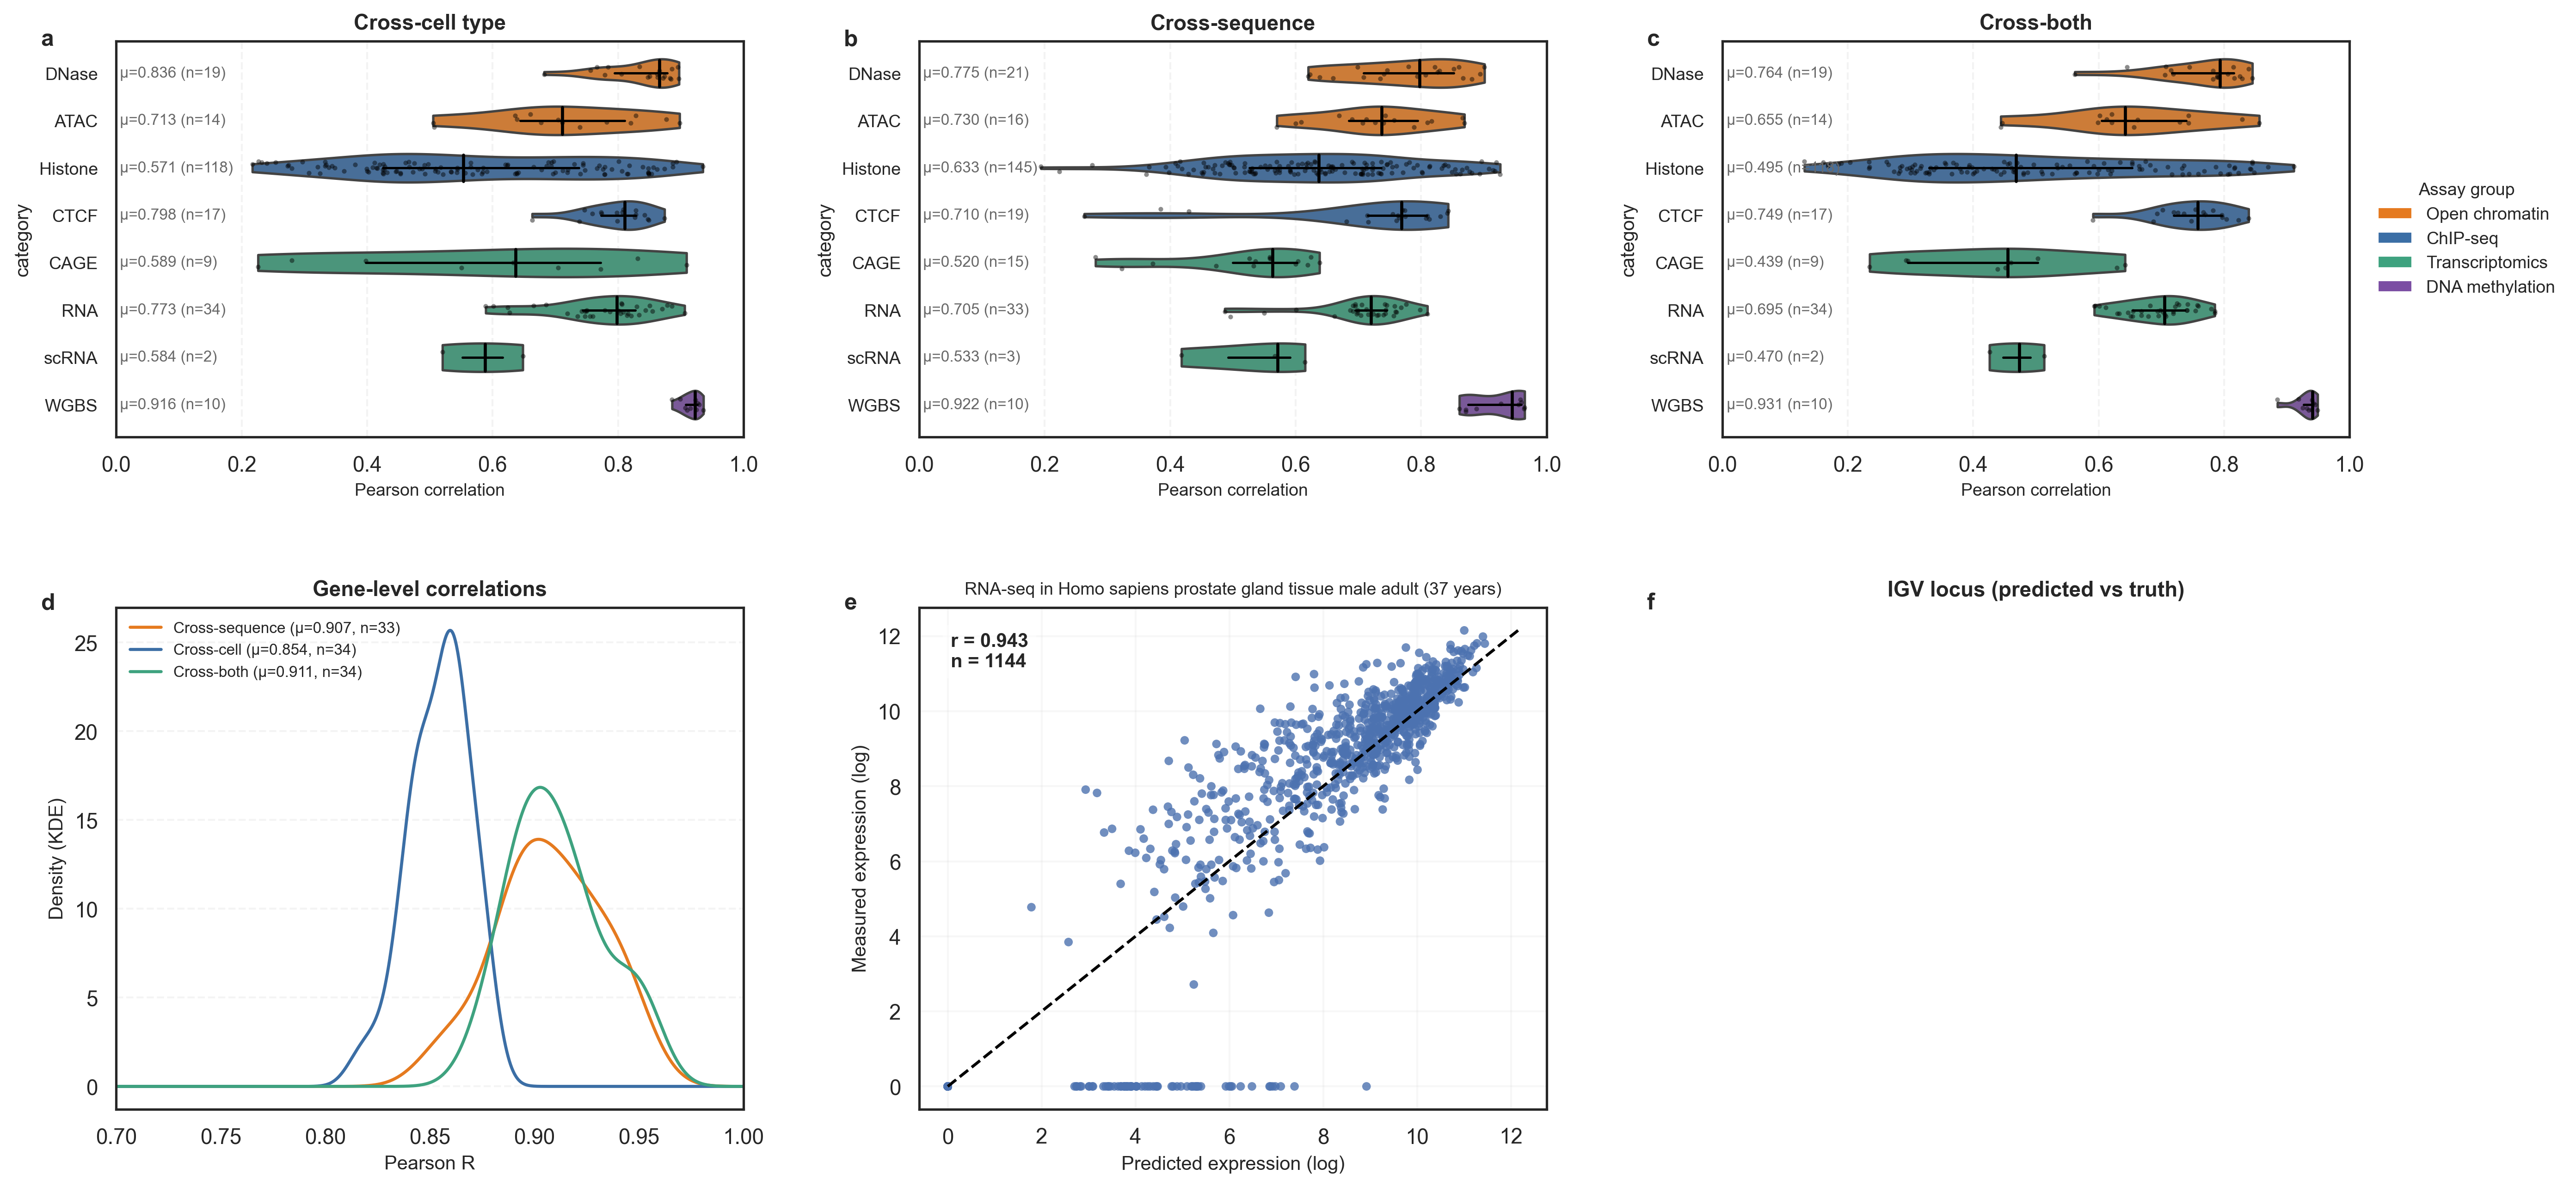

In [97]:
fig, axs = create_publication_figure(
     res_seq=res_cross_seq,
     res_cell=res_cross_cell,
     res_both=res_cross_both,
     gene_cross_seq=gene_cross_seq,
     gene_cross_cell=gene_cross_cell,
     gene_cross_both=gene_cross_both,
     encode_mat=encode_mat,
     grt_mat=grt_mat,
     genes_df=genes_df,
     cells_df=cells,
     igv_image_path=None,          
     sel_tissue='tissue267_rna_total',
     exclude_pairs=exclude,
     output_pdf='/project/deeprna/figures/paper/figure2.pdf',
     output_png=None
 )
plt.show()